# Scale-translation networks

This notebook isn't as complete a the SE(2) one (showing scale equivariance is a bit more involved due to interpolation and bandlimits). Instead this notebook shows some basic properties of the networks and some usage examples. For complete example in computer vision see the experiments repository.

-----------------------
## Importing libraries

Add the library to the system path via the relative folder structure:

In [1]:
import os,sys
splinets_source =  os.path.join(os.getcwd(),'..')
if splinets_source not in sys.path:
    sys.path.append(splinets_source)

Import below the gsplinets library with a specified group (whose class implementation can be found in gsplines/group). The layers object which is instantiated with the group sturcture, can generate convolution layers (e.g. layers.ConvRnG) which are equivariant w.r.t. the chosen group.

In [2]:
# Import the gsplintes package and the layers
import gsplinets_tf as gsplinets
layers = gsplinets.layers('R2R+') # The layers is instantiated with the group structure as input

The following are not used explictly but you can check your self which properties/attributes they possess

In [3]:
group = layers.group
G = group.G
Rn = group.Rn
H = group.H

Import the other libraries used in this demo

In [4]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

-------------------
## Equivariant convolution layers

Here we build a basic scale-translation equivariant network that consists of a lifting layer (ConvRnG) followed by a group convolution layer (ConvGG).

### The input feature map

In [5]:
Nxy = 21 # This spatial dimension
N_in = 5 # This many feature channels
B = 4 # Batch size
# For now we work with a placeholder
inputs_ph = tf.placeholder( dtype = tf.float32, shape = [None,Nxy,Nxy,N_in] )

### The lifting layer

In [6]:
# The size of the convolution kernels is set to:
kernel_size = 11 # 11x11 conv kernels (we set this rather high because we are going to scale the kernels and sample them on a fixed grid)
basis_size = 5 # parameterized 5x5 weights
scale_range = 2

# The settings for the lifting layer are:
N_out_1 = 13 # This many feature channels after the lifting layer
N_h_1 = 8 # This many rotations to sample (remember G = R^d \rtimes H, which in our current case H=SO(2), the rotation group)
h_grid_1 = layers.H.grid_global(N_h_1,scale_range) # The grid on which we sample the rotation. Global refers to that we aim to cover SO(2) globally, and equidistantly with N_h_1 samples
# Construct layer 1
l_1 = layers.ConvRnG(inputs_ph,N_out_1,kernel_size,h_grid_1,xx_basis_size = basis_size)
output_1 = l_1.outputs

The output tensor has one dimension extra because the domain of positions/translations is now expanded with a scale parameter axis which covers a scale range of 2 with 8 grid points.

In [7]:
output_1.shape

TensorShape([Dimension(None), Dimension(11), Dimension(11), Dimension(8), Dimension(13)])

### The group convolution layer

In [8]:
# The setting for the subseequent group convolution layer:
N_out_2 = 5 # This many outptu feature channels
N_h_2 = 8 # This many rotations to sample (does not have to be the same as in the previous layer (as we demo here), but it is often convenient to do so)
h_grid_2 = layers.H.grid_global(N_h_2,scale_range)
# Construct layer 2
l_2 = layers.ConvGG(output_1,N_out_2,kernel_size,h_grid_2,input_h_grid=h_grid_1,xx_basis_size = basis_size,h_basis_type='B_2')
output_2 = l_2.outputs

----------------
## What does the set of transformed lifting kernels look like?

First initialize it (give all trainable parameters their initial values)

In [9]:
initializer = tf.global_variables_initializer()
session = tf.Session(graph=tf.get_default_graph()) #-- Session created
session.run(initializer)

In the same way as done in the SE(2) demo we can transform the base convolution kernel via a scaling parameter via l_1.kernel(h), where h is a scale parameter. Let's do this for all scales in h_grid_1.

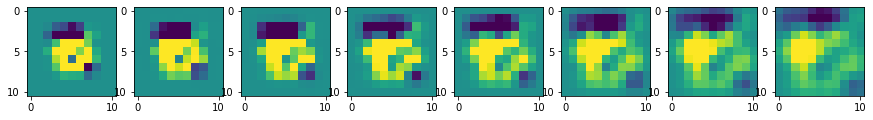

Base kernel: from left to right, scaled versions of the base kernel. These are used in the lifting layer.


In [11]:
plt.subplots(1,N_h_1,figsize=(15,15))
for i in range(N_h_1):
    kern = session.run(l_1.kernel(h_grid_1.grid[i]))
    plt.subplot(1,N_h_1,i+1)
    plt.imshow(kern[:,:,0,0],vmin=-0.03, vmax=0.03) # Only show for the first input channel and output channel
plt.show()
print('Base kernel: from left to right, scaled versions of the base kernel. These are used in the lifting layer.')

The same can be checked for the group convolution kernel. But now the convolution kernel is 3D. Increasing transformations are now plotted from top to bottom, and from left to right are the spatial slices of the conv kernels at the respective scale axis. From the figures below we see that a scaling of the 3D conv kernel corresponds to a spatial scaling and a shift along the scale axis.

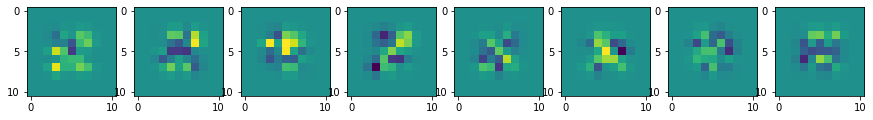

kernel(0): from left to right the planar kernels for each h


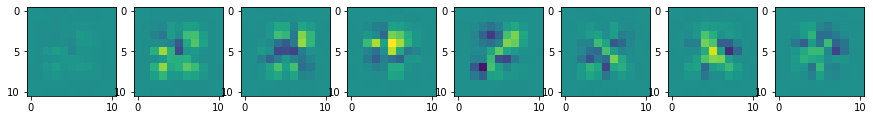

kernel(scale1): from left to right the planar kernels for each h


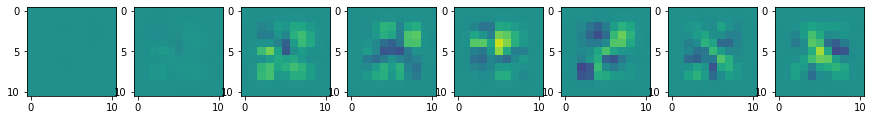

kernel(scale2): from left to right the planar kernels for each h
and so on...


In [12]:
kern_2_0 = (session.run(l_2.kernel()))
plt.subplots(1,N_h_1,figsize=(15,15))
for i in range(N_h_1):
    plt.subplot(1,N_h_1,i+1)
    plt.imshow(kern_2_0[:,:,i,0,0],vmin=-.03, vmax=.03)
plt.show()
print('kernel(0): from left to right the planar kernels for each h')
kern_2_1 = (session.run(l_2.kernel(h_grid_2.grid[1])))
plt.subplots(1,N_h_1,figsize=(15,15))
for i in range(N_h_1):
    plt.subplot(1,N_h_1,i+1)
    plt.imshow(kern_2_1[:,:,i,0,0],vmin=-0.03, vmax=0.03)
plt.show()
print('kernel(scale1): from left to right the planar kernels for each h')
kern_2_2 = (session.run(l_2.kernel(h_grid_2.grid[2])))
plt.subplots(1,N_h_1,figsize=(15,15))
for i in range(N_h_1):
    plt.subplot(1,N_h_1,i+1)
    plt.imshow(kern_2_2[:,:,i,0,0],vmin=-0.03, vmax=0.03)
plt.show()
print('kernel(scale2): from left to right the planar kernels for each h')
print('and so on...')

Note that in the above the full G-conv kernel enables interactions between all scales of the input feature map. Also note that the kernel is zero-padded and that kernel information is shifted out of the scale domain. It may therefore be more advantageous to localize the convolution kernels.

## One can also decide to work with G-conv kernels that are localized along the scale axis

We then set h_basis_local=True, and set h_basis_size=3 to use 3 weights along the h_axis. Additionally we set h_basis_type='B_1' such that each spline really only covers one bin, this makes the visualization clearer.

In [13]:
# The setting for the subseequent group convolution layer:
N_out_2 = 5 # This many outptu feature channels
N_h_2 = 8 # This many rotations to sample (does not have to be the same as in the previous layer (as we demo here), but it is often convenient to do so)
h_grid_2 = layers.H.grid_global(N_h_2,scale_range)
# Construct layer 2
l_2 = layers.ConvGG(output_1,N_out_2,kernel_size,h_grid_2,input_h_grid=h_grid_1,xx_basis_size = basis_size,h_basis_local=True,h_basis_size=3,h_basis_scale=h_grid_1.scale,h_basis_type='B_1')
output_2 = l_2.outputs

Again reinitialize the weights

In [14]:
initializer = tf.global_variables_initializer()
session = tf.Session(graph=tf.get_default_graph()) #-- Session created
session.run(initializer)

Show the kernels (we rescale for consistent plot range)

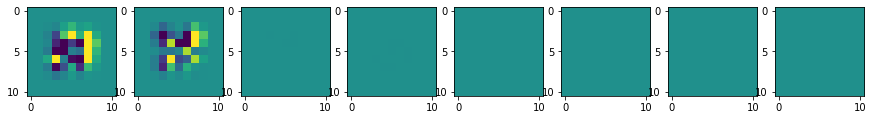

kernel(0): from left to right the planar kernels for each h


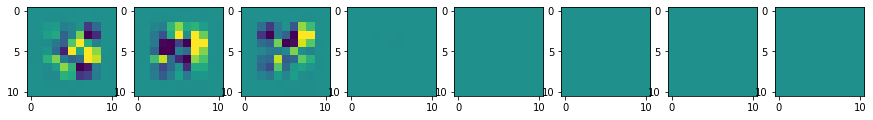

kernel(scale1): from left to right the planar kernels for each h


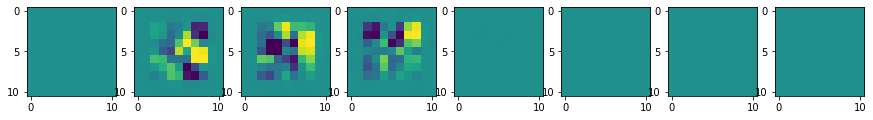

kernel(scale2): from left to right the planar kernels for each h


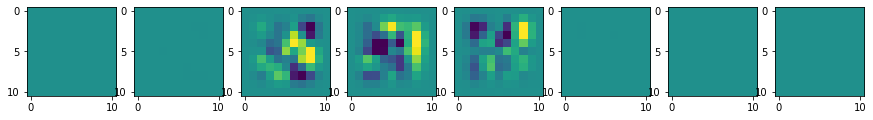

kernel(scale3): from left to right the planar kernels for each h


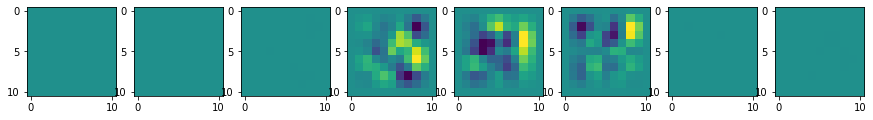

kernel(scale4): from left to right the planar kernels for each h
and so on...


In [15]:
kern_2_0 = (session.run(l_2.kernel()))
plt.subplots(1,N_h_1,figsize=(15,15))
for i in range(N_h_1):
    plt.subplot(1,N_h_1,i+1)
    plt.imshow(kern_2_0[:,:,i,0,0],vmin=-0.02, vmax=0.02)
plt.show()
print('kernel(0): from left to right the planar kernels for each h')
kern_2_1 = (session.run(l_2.kernel(h_grid_2.grid[1])))
plt.subplots(1,N_h_1,figsize=(15,15))
for i in range(N_h_1):
    plt.subplot(1,N_h_1,i+1)
    plt.imshow(kern_2_1[:,:,i,0,0],vmin=-0.02, vmax=0.02)
plt.show()
print('kernel(scale1): from left to right the planar kernels for each h')
kern_2_2 = (session.run(l_2.kernel(h_grid_2.grid[2])))
plt.subplots(1,N_h_1,figsize=(15,15))
for i in range(N_h_1):
    plt.subplot(1,N_h_1,i+1)
    plt.imshow(kern_2_2[:,:,i,0,0],vmin=-0.02, vmax=0.02)
plt.show()
print('kernel(scale2): from left to right the planar kernels for each h')
kern_2_3 = (session.run(l_2.kernel(h_grid_2.grid[3])))
plt.subplots(1,N_h_1,figsize=(15,15))
for i in range(N_h_1):
    plt.subplot(1,N_h_1,i+1)
    plt.imshow(kern_2_3[:,:,i,0,0],vmin=-0.02, vmax=0.02)
plt.show()
print('kernel(scale3): from left to right the planar kernels for each h')
kern_2_4 = (session.run(l_2.kernel(h_grid_2.grid[4])))
plt.subplots(1,N_h_1,figsize=(15,15))
for i in range(N_h_1):
    plt.subplot(1,N_h_1,i+1)
    plt.imshow(kern_2_4[:,:,i,0,0],vmin=-0.02, vmax=0.02)
plt.show()
print('kernel(scale4): from left to right the planar kernels for each h')
print('and so on...')

Note the the above kernels only encode interactions between neighbouring scales.